In [1]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from torch.autograd import Variable

In [2]:
LR = 0.01
BATCH_SIZE = 32
EPOCH = 20

In [3]:
df = pd.read_csv('./ml-latest-small/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
from sklearn import model_selection as ms
train_set, test_set = ms.train_test_split(df, test_size=0.25)
len(train_set), len(test_set)

(75627, 25209)

In [5]:
training_set = np.array(train_set, dtype = 'int')
testing_set = np.array(test_set, dtype = 'int')

In [6]:
num_users = df.userId.unique().shape[0]
num_items = df.movieId.unique().shape[0]
num_users, num_items

(610, 9724)

In [7]:
movie_movieId = df.movieId.unique().tolist()
movie_movieId.sort()
d = dict()
for i in range(0, len(movie_movieId)):
    d[movie_movieId[i]] = i

In [8]:
def user_item_matrix(data):
    ratings = np.zeros((num_users, num_items))
    for row in data.itertuples():
        ratings[row[1]-1, d[row[2]]] = row[3]
    return ratings

In [9]:
ratings = user_item_matrix(df)
train = user_item_matrix(train_set)
test = user_item_matrix(test_set)

In [10]:
train = torch.FloatTensor(train)
test = torch.FloatTensor(test)
input = Variable(train).unsqueeze(0).cuda()
target = input
torch_dataset = Data.TensorDataset(input, target)
loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,)

In [11]:
cuda = torch.device('cuda')
type(input)

torch.Tensor

In [12]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_items, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 20)
        self.fc4 = nn.Linear(20, num_items)
        self.activation = nn.Sigmoid()
        self.activation_t = nn.Tanh()
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation_t(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

In [13]:
net = Net()
net
loss_func = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=LR, betas=(0.9, 0.99))

In [14]:
loss_his = []
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(loader):          # for each training step
        output = net(b_x)  
        output[target == 0] = 0
        # get output for every net
        loss = loss_func(output, b_y)  # compute loss for every net
        opt.zero_grad()                # clear gradients for next train
        loss.backward()                # backpropagation, compute gradients
        opt.step()                     # apply gradients
        loss_his.append(loss.data.numpy())     # loss recoder
        print('Epoch: ', epoch, '| Step: ', step, '| train loss: ', loss.data.numpy())

Epoch:  0 | Step:  0 | train loss:  0.17004123
Epoch:  1 | Step:  0 | train loss:  0.16029276
Epoch:  2 | Step:  0 | train loss:  0.15063149
Epoch:  3 | Step:  0 | train loss:  0.14067446
Epoch:  4 | Step:  0 | train loss:  0.13051094
Epoch:  5 | Step:  0 | train loss:  0.12018148
Epoch:  6 | Step:  0 | train loss:  0.10977644
Epoch:  7 | Step:  0 | train loss:  0.0993556
Epoch:  8 | Step:  0 | train loss:  0.08899821
Epoch:  9 | Step:  0 | train loss:  0.07882372
Epoch:  10 | Step:  0 | train loss:  0.068979256
Epoch:  11 | Step:  0 | train loss:  0.05960836
Epoch:  12 | Step:  0 | train loss:  0.050846007
Epoch:  13 | Step:  0 | train loss:  0.042832654
Epoch:  14 | Step:  0 | train loss:  0.03569385
Epoch:  15 | Step:  0 | train loss:  0.029529523
Epoch:  16 | Step:  0 | train loss:  0.024394222
Epoch:  17 | Step:  0 | train loss:  0.02029867
Epoch:  18 | Step:  0 | train loss:  0.01720931
Epoch:  19 | Step:  0 | train loss:  0.015041683


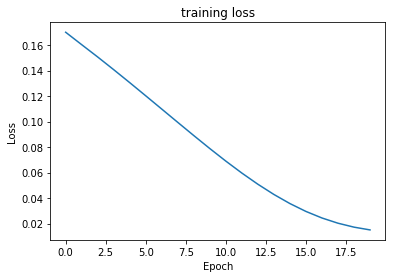

In [15]:
plt.plot(range(EPOCH), loss_his)
plt.title('training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [16]:
test_var = Variable(test).unsqueeze(0)
out = net(test_var)
out

tensor([[[ 3.3261,  3.6362,  3.1949,  ...,  3.1875, -0.4376,  3.6376],
         [ 3.3216,  3.6310,  3.1905,  ...,  3.1830, -0.4372,  3.6329],
         [ 3.3120,  3.6202,  3.1814,  ...,  3.1735, -0.4368,  3.6228],
         ...,
         [ 3.3261,  3.6362,  3.1949,  ...,  3.1875, -0.4376,  3.6376],
         [ 3.3005,  3.6071,  3.1708,  ...,  3.1622, -0.4362,  3.6112],
         [ 3.3260,  3.6360,  3.1946,  ...,  3.1873, -0.4376,  3.6374]]],
       grad_fn=<AddBackward0>)

In [17]:
out = out.detach().numpy()[0,:,:]

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_mse(pred, actual):
    # Ignore zero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(actual, pred)
def get_mae(pred, actual):
    # Ignore zero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(actual, pred)

test = user_item_matrix(test_set)
print('Autoencoder RMSE: ' + str(math.sqrt(get_mse(out, test))))
print('Autoencoder MAE: ' + str(math.sqrt(get_mse(out, test))))

Autoencoder RMSE: 1.2750413619316592
Autoencoder MAE: 1.2750413619316592
